# Adapter le code de scrapping d'AGODA pour mon corpus

Le code d'AGODA est disponible en suivant ce lien : https://github.com/mpuren/agoda/blob/main/listes_deputes/scrap_AN_legislatures.ipynb

## Code de scrapping d'AGODA

Je commence par tester le code d'AGODA pour ma législature, qui est indexé avec le nombre 47 sur le site de l'Assemblée nationale : https://www2.assemblee-nationale.fr/sycomore/liste/(legislature)/47

In [1]:
def scrap_AN_AGODA(debut, fin):
    import requests
    import bs4 as bs
    import pandas as pd
    debut = int(debut)
    fin = int(fin + 1)
    legislatures = range(debut, fin)
    url = "http://www2.assemblee-nationale.fr/sycomore/liste/(legislature)/"
    df_complet = pd.DataFrame(columns=["id_depute", "nom", "prenom", "lien","naissance_j", "naissance_m", "naissance_a", "deces_j", "deces_m", "deces_a" ])

    for leg in legislatures:
        mois = {"janvier": "1", "février": "2", "mars": "3", "avril": "4", "mai": "5", "juin": "6",\
                "juillet": "7", "août": "7", "septembre": "9", "octobre": "10", "novembre": "11", "décembre": "12"}
        r = requests.get(url + str(leg))
        pageWeb = r.text
        localisation_depart = pageWeb.find("<table class=\"sycomore\">")
        localisation_fin = pageWeb.find("</table>")
        tableau_seul = pageWeb[localisation_depart:localisation_fin]
        soup = bs.BeautifulSoup(tableau_seul, 'lxml')
        all_tr = list(soup.find_all("tr"))
        all_tr_data = all_tr[1:]
        
        nom = []
        prenom = []
        lien = []
        id_depute = []
        date_naissance = []
        date_deces = []
        
        for data in all_tr_data:
            
            id_depute.append(int(data.find('a').get('href').replace("/sycomore/fiche/(num_dept)/", "")))
            nom.append(data.td['data-sort'])
            prenom.append(data.td.get_text().replace(data.find('strong').string, "").strip())
            lien.append("http://www2.assemblee-nationale.fr" + data.find('a').get('href'))
            date_naissance.append(data.find_all('td')[1].string)
            date_deces.append(data.find_all('td')[2].string)
    
        data_dic = {"id_depute": id_depute, 
                    "nom": nom, 
                    "prenom": prenom, 
                    "lien": lien, 
                    "date_naissance": date_naissance,
                    "date_deces": date_deces} 

        df = pd.DataFrame(data_dic)
        df[["date_naissance", "naissance_m", "naissance_a"]] = df["date_naissance"].str.split(expand=True).replace("1er", "1")
        df[["date_deces", "deces_m", "deces_a"]] = df["date_deces"].str.split(expand=True).replace("1er", "1")
        df.rename(columns = {"date_naissance": "naissance_j", "date_deces": "deces_j"}, inplace=True)
        df = df[["id_depute", "nom", "prenom", "lien","naissance_j", "naissance_m", "naissance_a",\
                 "deces_j", "deces_m", "deces_a" ]]
       
        df["naissance_m"] = df["naissance_m"].map(mois, na_action = 'ignore')
        df["deces_m"] = df["deces_m"].map(mois, na_action = 'ignore')
# On enregistre localement le DF contenant la liste des députés de la législature | changement personnel
        chemin_fichier_csv = "/Users/charlielezin/Desktop/test_scrapping_députés/scrap_AGODA.csv" 
        df.to_csv(chemin_fichier_csv, sep=",", index=False)
# On insère la liste des députés de la législature dans le DF df_complet en supprimant les doublons
        df_complet = pd.concat([df_complet, df], ignore_index=True).drop_duplicates()
    
    df_complet.to_csv("legislature" + str(debut) + "_" + str(fin - 1))
    return df_complet ## ajout de ligne

In [2]:
df_general = scrap_AN_AGODA(47, 47)

In [3]:
df_general

,id_depute,nom,prenom,lien,naissance_j,naissance_m,naissance_a,deces_j,deces_m,deces_a
0,19,Abelin,"Pierre, Louis, Ernest, Armand",http://www2.assemblee-nationale.fr/sycomore/fi...,16,5,1909,23,5,1977
1,79,Alduy,Paul,http://www2.assemblee-nationale.fr/sycomore/fi...,4,10,1914,23,1,2006
2,94,Alliot,"Edouard, Denis, Marie, Joseph",http://www2.assemblee-nationale.fr/sycomore/fi...,26,2,1900,16,11,1981
3,97,Alloin,"Louis, Marie",http://www2.assemblee-nationale.fr/sycomore/fi...,3,7,1906,28,12,1978
4,132,André,Pierre,http://www2.assemblee-nationale.fr/sycomore/fi...,27,10,1903,9,4,1984
...,...,...,...,...,...,...,...,...,...,...
610,7235,Villard,Jean,http://www2.assemblee-nationale.fr/sycomore/fi...,24,2,1907,10,12,1986
611,7237,Villon-Ginsburger,Pierre,http://www2.assemblee-nationale.fr/sycomore/fi...,27,7,1901,6,11,1980
612,7259,Vitter,"Pierre, Joseph, Louis, Léon",http://www2.assemblee-nationale.fr/sycomore/fi...,29,10,1913,26,10,1995
613,7243,Vuillien,André,http://www2.assemblee-nationale.fr/sycomore/fi...,9,2,1924,6,5,2016


## Mon scrap, adapté d'AGODA

Mais je souhaite aussi et surtout récupérer le groupe parlementaire des députés, éventuellement leur département, informations que l'on trouve en passant on mode "alphabétique" sur la page web. Il faut donc adapter le code précédent. Pour ce code, je ne vais chercher que ces deux informations, ainsi que le lien de la fiche de chaque député. Ainsi, je pourrai fusionner les df des deux codes.

In [4]:
def mon_scrap_AN(debut, fin):
    import requests
    import bs4 as bs
    import pandas as pd
    
    debut = int(debut)
    fin = int(fin + 1)
    legislatures = range(debut, fin)
    url = "https://www2.assemblee-nationale.fr/sycomore/liste/(legislature)/"
    df_complet = pd.DataFrame(columns=["lien", "groupe_parlementaire", "departement"])

    for leg in legislatures:
        r = requests.get(url + str(leg) + "/(alpha)/true")
        pageWeb = r.text
        localisation_depart = pageWeb.find("<article>")
        localisation_fin = pageWeb.find("</article>")
        tableau_seul = pageWeb[localisation_depart:localisation_fin]
        soup = bs.BeautifulSoup(tableau_seul, 'lxml')
        all_li = list(soup.find_all("li"))
        all_li_data = all_li[1:]

        lien = []
        groupe_parlementaire = []
        departement = []
        

        for data in all_li_data:
            a_tag = data.find("a")
            lien.append("http://www2.assemblee-nationale.fr" + a_tag.get('href'))

            # Extraction du groupe parlementaire du député
            groupe_element = data.find("span", class_="block bottommargin")
            if groupe_element is not None:
                groupe_i_element = groupe_element.find("i")
                groupe_text = groupe_i_element.text.strip() if groupe_i_element is not None else ""
                groupe_text = groupe_text.replace("(", "").replace(")", "")
                groupe_parlementaire.append(groupe_text)
            else:
                groupe_parlementaire.append("")

            # Extraction du département du député
            departement_element = data.find("span", class_="block bottommargin")
            if departement_element is not None:
                departement_span_elements = departement_element.find_all("span")
                if len(departement_span_elements) >= 2:
                    departement_text = departement_span_elements[1].text.strip().replace(" - ", "")
                    departement_text = departement_text.replace("(", "").replace(")", "")
                    departement.append(departement_text)
                else:
                    departement.append("")
            else:
                departement.append("")
                                   
        data_dic = {
                    "lien": lien,
                    "groupe_parlementaire": groupe_parlementaire,
                    "departement": departement
                    
                }

        df = pd.DataFrame(data_dic)
        df = df[["lien", "groupe_parlementaire", "departement"]]
        df[['departement', 'groupe_parlementaire']] = df['groupe_parlementaire'].str.split(' - ', 1, expand=True)
        df_complet = df_complet.append(df, ignore_index=True)

# On enregistre localement le DF contenant la liste des députés de la législature | changement personnel
        chemin_fichier_csv = "/Users/charlielezin/Desktop/test_scrapping_députés/scrap_groupe_dep2.csv" 
        df.to_csv(chemin_fichier_csv, sep=",", index=False)
# On insère la liste des députés de la législature dans le DF df_complet en supprimant les doublons
        df_complet = pd.concat([df_complet, df], ignore_index=True).drop_duplicates()

    df_complet.to_csv("legislature" + str(debut) + "_" + str(fin - 1) + ".csv", sep=",", index=False)
    return df_complet ## ajout de ligne

In [5]:
df_groupe_dep = mon_scrap_AN(47, 47)

/var/folders/py/k9l9n4nj5l966__zkxgrfsj00000gn/T/ipykernel_42803/3622332321.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_complet = df_complet.append(df, ignore_index=True)


In [6]:
df_groupe_dep

,lien,groupe_parlementaire,departement
0,http://www2.assemblee-nationale.fr/sycomore/fi...,Socialiste,Pyrénées-Orientales
1,http://www2.assemblee-nationale.fr/sycomore/fi...,Indépendants et paysans d'action sociale,Aisne
2,http://www2.assemblee-nationale.fr/sycomore/fi...,Union et fraternité francaise,Rhône
3,http://www2.assemblee-nationale.fr/sycomore/fi...,Indépendants et paysans d'action sociale,Meurthe-et-Moselle
4,http://www2.assemblee-nationale.fr/sycomore/fi...,Républicain radical et radical-socialiste,Vienne
...,...,...,...
609,http://www2.assemblee-nationale.fr/sycomore/fi...,Mouvement républicain populaire,Rhône
610,http://www2.assemblee-nationale.fr/sycomore/fi...,Communiste,Allier
611,http://www2.assemblee-nationale.fr/sycomore/fi...,Paysan,Haute-Saône
612,http://www2.assemblee-nationale.fr/sycomore/fi...,Communiste,Saône-et-Loire


In [7]:
import pandas as pd
# Ajout des informations du député Abelin (qui était exclu du scrapping)
nouvelle_ligne = pd.Series({'lien': 'http://www2.assemblee-nationale.fr/sycomore/fiche/(num_dept)/19/(legislature)/47', 
                            'groupe_parlementaire': 'Mouvement républicain populaire', 'departement': 'Vienne'})

# La méthode concat sert à ajouter la nouvelle ligne en tant que première ligne
df_groupe_dep = pd.concat([nouvelle_ligne.to_frame().transpose(), df_groupe_dep], ignore_index=True)

In [8]:
df_groupe_dep ## 615 députés

,lien,groupe_parlementaire,departement
0,http://www2.assemblee-nationale.fr/sycomore/fi...,Mouvement républicain populaire,Vienne
1,http://www2.assemblee-nationale.fr/sycomore/fi...,Socialiste,Pyrénées-Orientales
2,http://www2.assemblee-nationale.fr/sycomore/fi...,Indépendants et paysans d'action sociale,Aisne
3,http://www2.assemblee-nationale.fr/sycomore/fi...,Union et fraternité francaise,Rhône
4,http://www2.assemblee-nationale.fr/sycomore/fi...,Indépendants et paysans d'action sociale,Meurthe-et-Moselle
...,...,...,...
610,http://www2.assemblee-nationale.fr/sycomore/fi...,Mouvement républicain populaire,Rhône
611,http://www2.assemblee-nationale.fr/sycomore/fi...,Communiste,Allier
612,http://www2.assemblee-nationale.fr/sycomore/fi...,Paysan,Haute-Saône
613,http://www2.assemblee-nationale.fr/sycomore/fi...,Communiste,Saône-et-Loire


In [9]:
# Je supprime la colonne lien, qui m'a servie à vérifier si les informations revenaient dans le même ordre
# à partir de mon code et avec celui d'AGODA
df_groupe_dep = df_groupe_dep.drop('lien', axis=1)
df_groupe_dep

,groupe_parlementaire,departement
0,Mouvement républicain populaire,Vienne
1,Socialiste,Pyrénées-Orientales
2,Indépendants et paysans d'action sociale,Aisne
3,Union et fraternité francaise,Rhône
4,Indépendants et paysans d'action sociale,Meurthe-et-Moselle
...,...,...
610,Mouvement républicain populaire,Rhône
611,Communiste,Allier
612,Paysan,Haute-Saône
613,Communiste,Saône-et-Loire


In [10]:
df_final = pd.concat([df_general, df_groupe_dep], axis=1) ## je concatène les deux dataframe

In [11]:
df_final

,id_depute,nom,prenom,lien,naissance_j,naissance_m,naissance_a,deces_j,deces_m,deces_a,groupe_parlementaire,departement
0,19,Abelin,"Pierre, Louis, Ernest, Armand",http://www2.assemblee-nationale.fr/sycomore/fi...,16,5,1909,23,5,1977,Mouvement républicain populaire,Vienne
1,79,Alduy,Paul,http://www2.assemblee-nationale.fr/sycomore/fi...,4,10,1914,23,1,2006,Socialiste,Pyrénées-Orientales
2,94,Alliot,"Edouard, Denis, Marie, Joseph",http://www2.assemblee-nationale.fr/sycomore/fi...,26,2,1900,16,11,1981,Indépendants et paysans d'action sociale,Aisne
3,97,Alloin,"Louis, Marie",http://www2.assemblee-nationale.fr/sycomore/fi...,3,7,1906,28,12,1978,Union et fraternité francaise,Rhône
4,132,André,Pierre,http://www2.assemblee-nationale.fr/sycomore/fi...,27,10,1903,9,4,1984,Indépendants et paysans d'action sociale,Meurthe-et-Moselle
...,...,...,...,...,...,...,...,...,...,...,...,...
610,7235,Villard,Jean,http://www2.assemblee-nationale.fr/sycomore/fi...,24,2,1907,10,12,1986,Mouvement républicain populaire,Rhône
611,7237,Villon-Ginsburger,Pierre,http://www2.assemblee-nationale.fr/sycomore/fi...,27,7,1901,6,11,1980,Communiste,Allier
612,7259,Vitter,"Pierre, Joseph, Louis, Léon",http://www2.assemblee-nationale.fr/sycomore/fi...,29,10,1913,26,10,1995,Paysan,Haute-Saône
613,7243,Vuillien,André,http://www2.assemblee-nationale.fr/sycomore/fi...,9,2,1924,6,5,2016,Communiste,Saône-et-Loire


In [12]:
import pandas as pd

# J'exporte le DataFrame dans un fichier CSV
df_final.to_csv('informations_députés.csv', index=False)

In [13]:
# Compter le nombre d'occurrences dans la colonne 'groupe_parlementaire'
occurrences = df_final['groupe_parlementaire'].value_counts()

# Afficher les résultats
print(occurrences)

Communiste                                                          145
Socialiste                                                          101
Indépendants et paysans d'action sociale                             88
Mouvement républicain populaire                                      74
Républicain radical et radical-socialiste                            60
Union et fraternité francaise                                        38
Républicains sociaux                                                 24
Union démocratique et socialiste de la Résistance et du RDA          21
Union et fraternité française                                        14
Rassemblement des gauches républicaines et du centre républicain     14
Paysan                                                               13
Indépendants d'outre-mer                                             10
Républicain progressiste                                              5
Non inscrit                                                     

Je récupère les informations des députés de gauche

In [14]:
groupes_parlementaires = ['Communiste', 'Socialiste', 'Républicain radical et radical-socialiste', 'Union démocratique et socialiste de la Résistance et du RDA']

df_gauche = df_final[df_final['groupe_parlementaire'].isin(groupes_parlementaires)]

In [15]:
df_gauche

,id_depute,nom,prenom,lien,naissance_j,naissance_m,naissance_a,deces_j,deces_m,deces_a,groupe_parlementaire,departement
1,79,Alduy,Paul,http://www2.assemblee-nationale.fr/sycomore/fi...,4,10,1914,23,1,2006,Socialiste,Pyrénées-Orientales
5,128,André,"Adrien, Baptiste, Honoré",http://www2.assemblee-nationale.fr/sycomore/fi...,29,5,1884,22,4,1965,Républicain radical et radical-socialiste,Vienne
7,153,Ansart,Gustave,http://www2.assemblee-nationale.fr/sycomore/fi...,5,3,1923,20,9,1990,Communiste,Nord
10,165,Anxionnaz,"Paul, Marius",http://www2.assemblee-nationale.fr/sycomore/fi...,31,12,1902,20,2,1997,Républicain radical et radical-socialiste,Marne
12,176,Arbeltier,"René, Albert",http://www2.assemblee-nationale.fr/sycomore/fi...,23,1,1897,10,9,1979,Socialiste,Seine-et-Marne
...,...,...,...,...,...,...,...,...,...,...,...,...
602,7221,Vergès,Paul,http://www2.assemblee-nationale.fr/sycomore/fi...,5,3,1925,12,11,2016,Communiste,La Réunion
603,7222,Vermeersch-Thorez,Jeannette,http://www2.assemblee-nationale.fr/sycomore/fi...,26,11,1910,5,11,2001,Communiste,Seine
604,7226,Véry-Hermence,Emmanuel,http://www2.assemblee-nationale.fr/sycomore/fi...,31,3,1904,19,6,1966,Socialiste,Martinique
611,7237,Villon-Ginsburger,Pierre,http://www2.assemblee-nationale.fr/sycomore/fi...,27,7,1901,6,11,1980,Communiste,Allier


In [16]:
df_gauche.to_csv('deputes_gauche.csv', index=False)

### Manipulations sur les df

In [20]:
# Liste des groupes parlementaires à corriger
groupes_a_corriger = {
    'Non inscrit': 'Non-inscrit',
    'Union et fraternité francaise': 'Union et fraternité française',
    'Non inscrit ': 'Non-inscrit'
}

# Effectuer les remplacements
df_final['groupe_parlementaire'] = df_final['groupe_parlementaire'].replace(groupes_a_corriger)

In [37]:
group_counts

Communiste                                                          145
Socialiste                                                          101
Indépendants et paysans d'action sociale                             88
Mouvement républicain populaire                                      74
Républicain radical et radical-socialiste                            60
Union et fraternité française                                        52
Républicains sociaux                                                 24
Union démocratique et socialiste de la Résistance et du RDA          21
Rassemblement des gauches républicaines et du centre républicain     14
Paysan                                                               13
Indépendants d'outre-mer                                             10
Non-inscrit                                                           7
Républicain progressiste                                              5
Name: groupe_parlementaire, dtype: int64

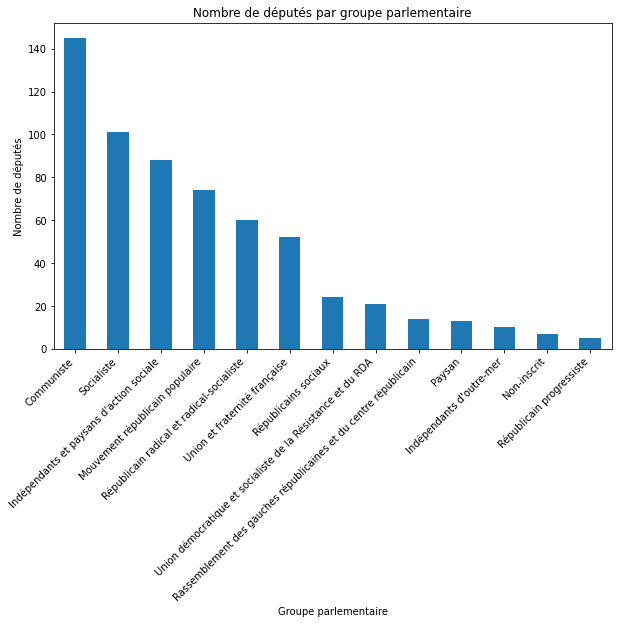

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que votre dataframe s'appelle "df" avec une colonne "GroupeParlementaire" contenant les noms des groupes

# Compter le nombre de députés par groupe parlementaire
group_counts = df_final['groupe_parlementaire'].value_counts()

# Créer un graphique à barres
group_counts.plot.bar(figsize=(10, 6))

# Ajuster les étiquettes des groupes parlementaires et aligner correctement avec les barres
plt.xticks(rotation=45, ha='right')

plt.title('Nombre de députés par groupe parlementaire')
plt.xlabel('Groupe parlementaire')
plt.ylabel('Nombre de députés')

# Enregistrer l'image
plt.savefig('graphique_groupesParl.png')

plt.show()
